In [2]:
import os
import sys
import pdb
import json
import copy
import glob
import h5py
import numpy as np
import pandas as pd
import scipy.io.wavfile
import time
import importlib
import tensorflow as tf

from tensorflow.python.training import py_checkpoint_reader

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import util_tfrecords
import util_signal
import util_cochlea
import util_network
import util_optimize
import util_evaluate
import util_figures
import util_stimuli
import util_misc


In [16]:
example_stim = np.load('example_stim.npz', allow_pickle=True)
for k in example_stim.files:
    print(k, len(example_stim[k]))

list_label = np.array(example_stim['label'], dtype=int)
list_softmax = np.array(example_stim['softmax'], dtype=np.float32)
list_coch = np.stack(example_stim['coch'])
list_wav = []
for itr_wav, wav in enumerate(example_stim['wav']):
    wav = np.frombuffer(wav, dtype=np.float32).reshape([
        example_stim['wav_width'][itr_wav],
        example_stim['wav_height'][itr_wav],
    ])
    list_wav.append(wav)
list_wav = np.stack(list_wav)
list_wav.shape, list_coch.shape, list_softmax.shape


coch_height 5
wav 5
coch_width 5
wav_height 5
wav_width 5
coch 5
softmax 5
label 5


((5, 2, 70049), (5, 39, 48000, 2), (5, 504))

In [15]:
ipd.display(ipd.Audio(rate=48000, data=list_wav[0]))


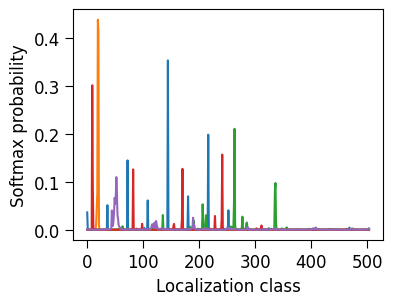

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(list_softmax.T)
ax = util_figures.format_axes(
    ax,
    str_xlabel='Localization class',
    str_ylabel='Softmax probability')
plt.show()


In [47]:
"""
Short demo of loading and testing one model
"""

dir_model = 'saved_models/tf2_model/archFrancl01'
fn_arch = os.path.join(dir_model, 'arch.json')
fn_config = os.path.join(dir_model, 'config.json')
fn_ckpt = os.path.join(dir_model, 'ckpt_BEST')
input_shape = (48000, 2)

with open(fn_arch, 'r') as f:
    list_layer_dict = json.load(f)
with open(fn_config, 'r') as f:
    CONFIG = json.load(f)

def model_io_function(x):
    """
    This functions describes how the model should convert inputs to outputs.
    It will be used to build the tensorflow model object.
    """
    y = x
    if CONFIG.get('kwargs_cochlea', {}):
        msg = "expected input with shape [batch, time, channel=2]"
        assert (len(y.shape) == 3) and (y.shape[-1] == 2), msg
        # Cochlear model for ear index 0
        y0, _ = util_cochlea.cochlea(y[..., 0], **copy.deepcopy(CONFIG['kwargs_cochlea']))
        # Cochlear model for ear index 1
        y1, _ = util_cochlea.cochlea(y[..., 1], **copy.deepcopy(CONFIG['kwargs_cochlea']))
        # Binaural cochlear model representation with shape [batch, freq, time, channel=2]
        y = tf.concat([y0[..., tf.newaxis], y1[..., tf.newaxis]], axis=-1)
        msg = "expected cochlear model output with shape [batch, freq, time, channel=2]"
        assert (len(y.shape) == 4) and (y.shape[-1] == 2), msg
    y, _ = util_network.build_network(y, list_layer_dict, n_classes_dict=CONFIG['n_classes_dict'])
    return y
    

tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=input_shape, batch_size=None, dtype=tf.float32)
model = tf.keras.Model(inputs=inputs, outputs=model_io_function(inputs))

# model.summary()


[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'up': 1, 'window_length': 4097}
[cochlea] half-wave rectified resampled subbands
[cochlea] applied 0.3 power compression to subbands
[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'up': 1, 'window_length': 4097}
[cochlea] half-wave rectified resampled subbands
[cochlea] applied 0.3 power compression to subbands


In [61]:
fn = '/om2/user/msaddler/data_localize/FLDv01/valid/stim_000000-004763.hdf5'
with h5py.File(fn, 'r') as f:
#     for k in util_misc.get_hdf5_dataset_key_list(f):
#         print(k, f[k].shape)
    
    sr_hdf5 = f['sr'][0]
    sr = 48000
    IDX = slice(500, 508)
    
    tmp_y = f['signal'][IDX]
    tmp_y = scipy.signal.resample_poly(tmp_y, up=sr_hdf5, down=sr, axis=-1)
    tmp_y = tmp_y[:, 22800:22800 + 48000, :]
    y = tmp_y / tmp_y.max()
    azim = f['foreground_azimuth'][IDX]
    elev = f['foreground_elevation'][IDX]
    
loc_label_true = np.array((elev / 10) * 72 + (azim / 5), dtype=int)

y_out = model(y)['label_loc_int'].numpy()
y_pred = scipy.special.softmax(y_out, axis=-1)
loc_label_pred = np.argmax(y_out, axis=-1)

loc_label_pred, loc_label_true


(array([130, 390, 390, 355, 355,  72, 130, 231]),
 array([180, 123, 258, 366, 403, 441, 494,   5]))

In [17]:
def load_legacy_checkpoint(model, fn_ckpt, verbose=True):
    """
    Loads weights from Francl & McDermott (2022) tensorflow1
    checkpoints into tensorflow2 Keras model objects.
    """
    model_variables = {v.name: v for v in model.variables}
    reader = py_checkpoint_reader.NewCheckpointReader(fn_ckpt)
    map_ckpt_var_to_shape = reader.get_variable_to_shape_map()
    relevant_variables = {}
    
    for k_ckpt in sorted(map_ckpt_var_to_shape.keys()):
        if ('Adam' not in k_ckpt) and (k_ckpt not in ['beta1_power', 'beta2_power']):
            k_rel = k_ckpt
            if 'norm' in k_rel:
                k_rel = k_rel.replace('batch_normalization', 'batch_norm')
                k_rel = k_rel.replace('norm/', 'norm_0/')
                if 'archFrancl01' in fn_ckpt:
                    k_rel = k_rel.replace('norm_8', 'norm_fc_intermediate')
                elif 'archFrancl02' in fn_ckpt:
                    k_rel = k_rel.replace('norm_9', 'norm_fc_intermediate')
                elif 'archFrancl03' in fn_ckpt:
                    k_rel = k_rel.replace('norm_10', 'norm_fc_intermediate')
                elif 'archFrancl04' in fn_ckpt:
                    k_rel = k_rel.replace('norm_8', 'norm_fc_intermediate')
                elif 'archFrancl05' in fn_ckpt:
                    k_rel = k_rel.replace('norm_9', 'norm_fc_intermediate')
                elif 'archFrancl06' in fn_ckpt:
                    k_rel = k_rel.replace('norm_7', 'norm_fc_intermediate')
                elif 'archFrancl07' in fn_ckpt:
                    k_rel = k_rel.replace('norm_7', 'norm_fc_intermediate')
                elif 'archFrancl08' in fn_ckpt:
                    k_rel = k_rel.replace('norm_9', 'norm_fc_intermediate')
                elif 'archFrancl09' in fn_ckpt:
                    k_rel = k_rel.replace('norm_9', 'norm_fc_intermediate')
                elif 'archFrancl10' in fn_ckpt:
                    k_rel = k_rel.replace('norm_4', 'norm_fc_intermediate')
                else:
                    raise ValueError('NO IDEA HOW TO DEAL WITH THIS ARCHITECTURE')
            if 'wb' in k_rel:
                tmp = k_rel.split('_')
                k_rel = 'conv_{}/bias'.format(tmp[1])
            if 'wc' in k_rel:
                tmp = k_rel.split('_')
                k_rel = 'conv_{}/kernel'.format(tmp[1])
            if 'fc' in k_rel:
                k_rel = k_rel.replace('conv_fc', 'fc_intermediate')
            if 'out' in k_rel:
                k_rel = k_rel.replace('conv_out', 'fc_top')
            k_rel = k_rel + ':0'
            
            consumed = False
            for v in model.variables:
                if k_rel == v.name:
                    if not map_ckpt_var_to_shape[k_ckpt] == v.shape:
                        print('--> {}:{}    |    {}:{}'.format(v.name, v.shape, k_ckpt, map_ckpt_var_to_shape[k_ckpt]))
                    relevant_variables[k_rel] = reader.get_tensor(k_ckpt)
                    consumed = True
            if (not consumed) and (verbose):
                print('IGNORING VARIABLE IN CKPT: {}'.format(k_rel), k_ckpt, map_ckpt_var_to_shape[k_ckpt])
    
    for v in model.variables:
        if v.name in relevant_variables:
            assert v.shape == relevant_variables[v.name].shape
            assert v.dtype == relevant_variables[v.name].dtype
            v.assign(relevant_variables[v.name])
        else:
            raise ValueError('VARIABLE MISSING FROM CKPT: {} {}'.format(v.name, v.shape))
    return


In [24]:
"""
I organize my models as individual directories. Each model has it's own directory containing:
- `config.json`: specifies the cochlear model, all training parameters, and output shape of the network
- `arch.json`: specifies the architecture of the neural network
- Model checkpoint(s)
- Training log(s)
- Model evaluation outputs

Below is a config dictionary (typically stored as `config.json` in the individual model directories)
I've used to train a variant of the Francl & McDermott (2022) model directly on sound waveforms.

The important parts are `kwargs_cochlea` and `n_classes_dict`:
- `kwargs_cochlea`: specifies the parameters of the cochlear model built in tensorflow
- `n_classes_dict`: specifies the output layer's shape and name
"""

CONFIG = {
    "kwargs_cochlea": {
        "config_filterbank": {
            "max_hi": 20000.0,
            "min_lo": 30.0,
            "mode": "half_cosine_filterbank",
            "num_cf": 39
        },
        "config_subband_processing": {
            "power_compression": 0.3,
            "rectify": True
        },
        "kwargs_nnresample_poly_filter_input": {},
        "kwargs_nnresample_poly_filter_output": {
            "down": 6,
            "up": 1,
            "window_length": 4097
        },
        "sr_cochlea": 48000,
        "sr_input": 48000,
        "sr_output": 8000
    },
    "kwargs_dataset_from_tfrecords": {
        "buffer_size_prefetch": 5,
        "buffer_size_shuffle": 100,
        "bytes_description": "config_bytes_description.pckl",
        "feature_description": "config_feature_description.pckl",
        "features_to_exclude": [
            "nervegram_meanrates"
        ]
    },
    "kwargs_optimize": {
        "basename_ckpt_best": "ckpt_BEST",
        "basename_ckpt_epoch": None,
        "basename_log": "log_optimize.csv",
        "batch_size": 16,
        "early_stopping_baseline": None,
        "early_stopping_min_delta": 0,
        "early_stopping_patience": None,
        "epochs": 50,
        "key_inputs": "signal",
        "key_outputs": "label_loc_int",
        "kwargs_loss": {
            "from_logits": True,
            "name": "SparseCategoricalCrossentropy",
            "weight": 1.0
        },
        "kwargs_optimizer": {
            "amsgrad": False,
            "beta_1": 0.9,
            "beta_2": 0.999,
            "epsilon": 1e-07,
            "learning_rate": 0.001,
            "name": "Adam"
        },
        "monitor_metric": "val_accuracy",
        "monitor_mode": "max",
        "steps_per_epoch": 10000,
        "validation_steps": 500
    },
    "n_classes_dict": {
        "label_loc_int": 504
    }
}


In [25]:
tf.get_logger().setLevel('ERROR') # Suppress warnings about variable identifiers not matching

list_dir_model = glob.glob('saved_models/tf2_model/archFrancl??')
input_shape = (48000, 2)

for dir_model in list_dir_model:
    fn_arch = os.path.join(dir_model, 'arch.json')
    fn_config = os.path.join(dir_model, 'config.json')
    fn_ckpt_tf2 = os.path.join(dir_model, 'ckpt_BEST')
    fn_ckpt_tf1 = os.path.join(dir_model.replace('tf2_model', 'tf1_model'), 'model.ckpt-100000')
    
    with open(fn_arch, 'r') as f:
        list_layer_dict = json.load(f)
    with open(fn_config, 'w') as f:
        json.dump(CONFIG, f, sort_keys=True, indent=4)
    
    def model_io_function(x):
        """
        This functions describes how the model should convert inputs to outputs.
        It will be used to build the tensorflow model object.
        """
        y = x
        if CONFIG.get('kwargs_cochlea', {}):
            msg = "expected input with shape [batch, time, channel=2]"
            assert (len(y.shape) == 3) and (y.shape[-1] == 2), msg
            # Cochlear model for ear index 0
            y0, _ = util_cochlea.cochlea(y[..., 0], **copy.deepcopy(CONFIG['kwargs_cochlea']))
            # Cochlear model for ear index 1
            y1, _ = util_cochlea.cochlea(y[..., 1], **copy.deepcopy(CONFIG['kwargs_cochlea']))
            # Binaural cochlear model representation with shape [batch, freq, time, channel=2]
            y = tf.concat([y0[..., tf.newaxis], y1[..., tf.newaxis]], axis=-1)
            msg = "expected cochlear model output with shape [batch, freq, time, channel=2]"
            assert (len(y.shape) == 4) and (y.shape[-1] == 2), msg
        y, _ = util_network.build_network(y, list_layer_dict, n_classes_dict=CONFIG['n_classes_dict'])
        return y
    
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=input_shape, batch_size=None, dtype=tf.float32)
    model = tf.keras.Model(inputs=inputs, outputs=model_io_function(inputs))
    
    weights_init = {v.name: v.numpy() for v in model.weights}
    print('Loading weights: {}'.format(fn_ckpt_tf1))
    load_legacy_checkpoint(model, fn_ckpt_tf1) # Load weights from tensorflow1 checkpoint
    weights_tf1 = {v.name: v.numpy() for v in model.weights}
    print('Loading weights: {}'.format(fn_ckpt_tf2))
    model.load_weights(fn_ckpt_tf2) # Load weights from tensorflow2 checkpoint
    weights_tf2 = {v.name: v.numpy() for v in model.weights}
    
    for k in sorted(weights_init.keys()):
        tf1_equals_init = np.array_equal(weights_init[k], weights_tf1[k])
        tf2_equals_init = np.array_equal(weights_init[k], weights_tf2[k])
        tf2_equals_tf1 = np.array_equal(weights_tf2[k], weights_tf1[k])
        msg = "Unexpected checkpoint behavior for variable {} with shape {}".format(k, weights_init[k].shape)
        if tf1_equals_init:
            print(msg)
        if tf2_equals_init:
            print(msg)
        if not tf2_equals_tf1:
            print(msg)


[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'up': 1, 'window_length': 4097}
[cochlea] half-wave rectified resampled subbands
[cochlea] applied 0.3 power compression to subbands
[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'up': 1, 'window_length': 4097}
[cochlea] half-wave rectified resampled subbands
[cochlea] applied 0.3 power compression to subbands
Loading weights: saved_models/tf1_model/archFrancl01/model.ckpt-100000
Loading weights: saved_models/tf2_model/archFrancl01/ckpt_BEST
[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'down': 6, 'up': 1, 'window_length': 4097}
[cochlea] 

In [26]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48000, 2)]   0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 48000)       0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 48000)       0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

                                                                                                  
 fc_intermediate (Dense)        (None, 512)          305070592   ['flatten_end_conv[0][0]']       
                                                                                                  
 relu_fc_intermediate (ReLU)    (None, 512)          0           ['fc_intermediate[0][0]']        
                                                                                                  
 batch_norm_fc_intermediate (Ba  (None, 512)         2048        ['relu_fc_intermediate[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['batch_norm_fc_intermediate[0][0
                                                                 ]']                              
          